# Managing Big Data for Connected Devices

## 420-N63-NA

## Kawser Wazed Nafi
 ----------------------------------------------------------------------------------------------------------------------------------

## Advanced Data Analysis with PySpark and Data Visualization

In this Lab, we are going to use perform some advance data analysis operation and visualization with a new set of data. We have already performed a number of operations with PySpark given data. Operations are done to perform analysis on data, but visualization is required to understand the data distribution, which is one of the most important aspects of Managing Big Data and Data Analysis.

The data we are using is a subset of Instacart Market Basket Analysis. The full data is much bigger. You can read more about on  [Kaggle](https://www.kaggle.com/c/instacart-market-basket-analysis). Kaggle is a nice platform to practice data science skills and enter competitions created by companies. 

At the beginning, I am going to introduce you with the given dataset.

## Orders_40.csv

Each order has an order id. The order also has a user id that specifies the user who made this order. We can also know on which day of week and the hour of the day the order was made. Users also could have made orders before. The last column tells when was their previous order.

In [168]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, asc,desc, collect_list, count, when, isnull, isnan, size, sum, split
ss = SparkSession.builder.master("local[4]").appName("orders_products").getOrCreate()
sc = ss.sparkContext

dfOrders = ss.read.csv('instacart-market-basket-analysis/orders_40.csv', header=True, inferSchema=True)
dfOrders.show(n=2)

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 2 rows



## Exercise 1

Find the following: 
- The total number of orders
- The user with the most orders
- The day of the week with the highest/lowest number of orders 
- The hour of the day with the highest/lowest number of orders

In [2]:
dfOrders.select(count('order_id')).show()

dfOrders.printSchema()

userCount = dfOrders.groupBy(col('user_id')).count()
userCount.orderBy(col('count').desc()).show()

dowCount = dfOrders.groupBy(col('order_dow')).count()
maxOrderDOW = dowCount.orderBy(col('count').desc())
maxOrderDOW.show()

minOrderDOW = dowCount.orderBy(col('count').asc())
minOrderDOW.show()

hodCount = dfOrders.groupBy(col('order_hour_of_day')).count()
maxOrderHOD = hodCount.orderBy(col('count').desc())
maxOrderHOD.show()

minOrderHOD = hodCount.orderBy(col('count').asc())
minOrderHOD.show()

+---------------+
|count(order_id)|
+---------------+
|        1341835|
+---------------+

root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)

+-------+-----+
|user_id|count|
+-------+-----+
|  22395|  100|
|   2231|  100|
|  21288|  100|
|   8086|  100|
|   2387|  100|
|  18085|  100|
|   3377|  100|
|   7744|  100|
|   7120|  100|
|    210|  100|
|   8664|  100|
|  10502|  100|
|   8085|  100|
|  16265|  100|
|  14437|  100|
|  12102|  100|
|   8779|  100|
|   4229|  100|
|  15221|  100|
|  11334|  100|
+-------+-----+
only showing top 20 rows

+---------+------+
|order_dow| count|
+---------+------+
|        0|235199|
|        1|230548|
|        2|183572|
|        5|177956|
|        6|176422|
|        3|171259|
|        4

## order_products_40.csv
Every row of this file shows a product that belongs to an order. By combining the products based on the order id, we can get all the products per order

In [3]:
dfOrderProducts = ss.read.csv('instacart-market-basket-analysis/order_products_40.csv', header=True)
dfOrderProducts.show(n=2)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
+--------+----------+-----------------+---------+
only showing top 2 rows



## collect_list
In this case we can groupBy the order_id and we want to collect all the product_ids per order_id. We can use the `collect_list` function from pyspark (check the import at the top of the notebook) which will groupBy the items by creating an array of them. 

In [4]:
dfOrdersWithItems = dfOrderProducts.groupBy(col('order_id')).agg(collect_list('product_id').alias('items'))
dfOrdersWithItems.show(n=2, truncate=False) #setting truncate to False so that we see the full output

+--------+-------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|items                                                                                                                                      |
+--------+-------------------------------------------------------------------------------------------------------------------------------------------+
|10000   |[6587, 10369, 10017, 28597, 22035, 35108, 13176, 4920, 8174, 9495, 37472, 23959, 30391, 40396]                                             |
|100008  |[17981, 29529, 25146, 35406, 48118, 2708, 29487, 14233, 19871, 49683, 40910, 29309, 45441, 27020, 22754, 30532, 46844, 35762, 10755, 47058]|
+--------+-------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



## Exercise 2

For the ratings.csv file, can you aggregate all the ratings based on the movie id? Please print the first three movies.

In [5]:
dfRatings = ss.read.csv('Movies/ratings.csv', header=True, inferSchema=True)

dfRatingsPerMovies = dfRatings.groupBy(col('movieId')).agg(collect_list('rating').alias('ratings'))
dfRatingsPerMovies.show(n=3, truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## size 

We can use the size function from spark on a column which will give us the size of the values in the column. In this case the values are arrays, so we will get the size of the arrays.



In [6]:
dfOrdersWithItems.select(col('order_id'), size('items')).show(n=2)

+--------+-----------+
|order_id|size(items)|
+--------+-----------+
|   10000|         14|
|  100008|         20|
+--------+-----------+
only showing top 2 rows



## products.csv
This is a list of products with their names, the department they belong to and the aisle they are stored at.

In [7]:
dfProducts = ss.read.csv('instacart-market-basket-analysis/products.csv', header=True)

## Exercise 3
- Find the product (full information) that is sold the most
- Find the product that is sold the most on sundays
- Find the orders with 2 products or less and display some of those orders with a list of names of the products per order
- Find how many orders there is with each possible size of products in the order. For example 1000 of orders with 1 items, 2000 orders with 2 products etc. The returned dataframe should have 2 columns: size(items) and count

In [8]:
dfOrdersCount = dfOrderProducts.groupBy(col('product_id')).count()
dfOrdersCount.show()

dfFullOrders = dfProducts.join(dfOrdersCount, 'product_id')
dfFullOrders.orderBy(col('count').desc()).show(truncate=False)


+----------+-----+
|product_id|count|
+----------+-----+
|     48370|  291|
|     10096|   74|
|     16974|  235|
|     18306|    8|
|     39581|  697|
|     48493|   35|
|     15269|  186|
|     35350|   37|
|     23459|   16|
|     35004|  637|
|       691|  246|
|     28473|  130|
|     24504|   11|
|     32812|   15|
|     10436|   18|
|     38672|  116|
|      7762|  128|
|     44032|   30|
|     44717|   74|
|     10351|   80|
+----------+-----+
only showing top 20 rows

+----------+------------------------+--------+-------------+-----+
|product_id|product_name            |aisle_id|department_id|count|
+----------+------------------------+--------+-------------+-----+
|24852     |Banana                  |24      |4            |36889|
|13176     |Bag of Organic Bananas  |24      |4            |29238|
|21137     |Organic Strawberries    |24      |4            |20370|
|21903     |Organic Baby Spinach    |123     |4            |18675|
|47209     |Organic Hass Avocado    |24      |4  

In [98]:
dfSundayOrders = dfOrders.filter(col('order_dow') == 6)
dfSundayOrdersFull = dfSundayOrders.join(dfOrderProducts, 'order_id').join(dfFullOrders, 'product_id')
dfSundayOrdersGrouped = dfSundayOrdersFull.groupBy(col('product_name')).agg(collect_list(col('order_id')).alias('orders'))
dfSundayOrdersGrouped.select(col('product_name'), size('orders').alias('orders')).orderBy(col('orders').desc()).show(truncate=False)


+----------------------+------+
|product_name          |orders|
+----------------------+------+
|Banana                |1965  |
|Bag of Organic Bananas|1507  |
|Organic Strawberries  |1163  |
|Organic Baby Spinach  |1068  |
|Organic Hass Avocado  |843   |
|Organic Avocado       |708   |
|Limes                 |684   |
|Large Lemon           |637   |
|Strawberries          |605   |
|Organic Whole Milk    |595   |
|Organic Raspberries   |591   |
|Organic Garlic        |524   |
|Organic Yellow Onion  |491   |
|Organic Zucchini      |447   |
|Cucumber Kirby        |418   |
|Organic Blueberries   |407   |
|Organic Grape Tomatoes|386   |
|Yellow Onions         |370   |
|Organic Lemon         |367   |
|Organic Cilantro      |360   |
+----------------------+------+
only showing top 20 rows



In [123]:
dfFullOrderProducts = dfProducts.join(dfOrderProducts, 'product_id')
dfFullOrderProducts.show()
dfTargetOrders = dfFullOrderProducts.groupBy(col('order_id')).agg(collect_list(col('product_name')).alias('product_name'))
dfTargetOrders.filter(size(col('product_name')) <= 2).show(truncate=False)

+----------+--------------------+--------+-------------+--------+-----------------+---------+
|product_id|        product_name|aisle_id|department_id|order_id|add_to_cart_order|reordered|
+----------+--------------------+--------+-------------+--------+-----------------+---------+
|     33120|  Organic Egg Whites|      86|           16|       2|                1|        1|
|     28985|Michigan Organic ...|      83|            4|       2|                2|        1|
|      9327|       Garlic Powder|     104|           13|       2|                3|        0|
|     45918|      Coconut Butter|      19|           13|       2|                4|        1|
|     30035|   Natural Sweetener|      17|           13|       2|                5|        0|
|     17794|             Carrots|      83|            4|       2|                6|        1|
|     40141|Original Unflavor...|     105|           13|       2|                7|        1|
|      1819|All Natural No St...|      88|           13|    

In [147]:
dfFullOrderProducts = dfOrderProducts.join(dfOrders, 'order_id')
dfProductSizes = dfFullOrderProducts.groupBy(col('product_id')).agg(collect_list(col('order_id')).alias('order_ids'))
dfOrderSizes = dfProductSizes.select(col('product_id'), size('order_ids').alias('orders'))
dfOrderSizes.groupBy('orders').count().show()

+------+-----+
|orders|count|
+------+-----+
|   463|    1|
|   148|    9|
|   471|    3|
|    31|  125|
|    85|   17|
|   251|    7|
|   137|    8|
|    65|   45|
|   883|    1|
|   458|    1|
|    53|   64|
|   133|   13|
|   296|    6|
|    78|   19|
|   322|    6|
|   108|   12|
|   155|   12|
|    34|  119|
|   193|    8|
|   368|    1|
+------+-----+
only showing top 20 rows



## Getting the number of orders per size of basket


In [9]:
#getting for each order the list of products

#getting the size of items 
dfSizeOfOrder = dfOrdersWithItems.select(col('order_id'), size('items'))

dfCountPerSize = dfSizeOfOrder.groupBy('size(items)').count()
dfCountPerSize.show(n=2)

+-----------+-----+
|size(items)|count|
+-----------+-----+
|         31|  721|
|         65|    4|
+-----------+-----+
only showing top 2 rows



## Exercise 4
Like the problem given in previous context, can you find out the number of ratings per movie from the ratings.csv file?


In [10]:
dfRatingsSize = dfRatingsPerMovies.select(col('movieId'), size('ratings'))
dfRatingsSize.show(n=10)

+-------+-------------+
|movieId|size(ratings)|
+-------+-------------+
|      1|          215|
|      2|          110|
|      3|           52|
|      4|            7|
|      5|           49|
|      6|          102|
|      7|           54|
|      8|            8|
|      9|           16|
|     10|          132|
+-------+-------------+
only showing top 10 rows



## Plotting the Data!

Spark does not have plotting api. But pandas dataframes has! and spark dataframes can be easily converted to pandas. You usually do that once you've finished the analysis and got smaller data representing the result. Because the pandas dataframe will be loaded into your computer (RAM) after the spark dataframe evaulates everything and collects the result.

In [11]:
## we will ignore any size we have that has less than 100 orders. 
## We will also change the name of the column from size(items) to size
dfCountPerSizeCleaned = dfCountPerSize.filter(col('count') > 100)\
.select(col('size(items)').alias('size'), col('count'))

dfCountPerSizeCleaned.show(n=2)

# we can collect all the data into a pandas dataframe by using toPandas function
dfCountPerSizePandas = dfCountPerSizeCleaned.toPandas()
dfCountPerSizePandas

+----+-----+
|size|count|
+----+-----+
|  31|  721|
|  34|  479|
+----+-----+
only showing top 2 rows



,size,count
0,31,721
1,34,479
2,28,1157
3,27,1363
4,26,1596
5,12,10178
6,22,2660
7,1,12258
8,13,9027
9,6,17742


## Plot
We can use the plot function. Pandas plotting uses matplotlib for plotting. By default the plot will use a line to plot the data but we can change the kind of the plot to a bar. 

check the full documentation: 
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

<AxesSubplot: xlabel='size'>

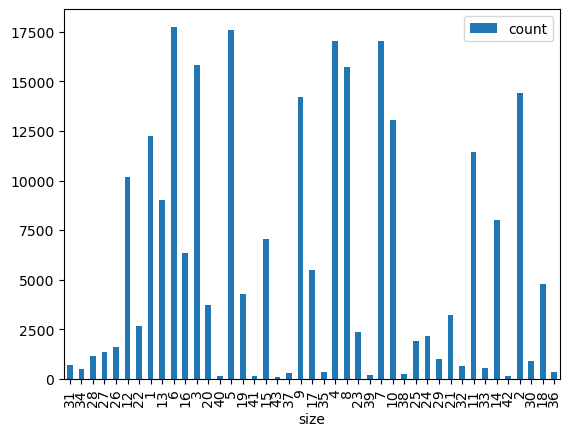

In [12]:
# we will specify the labels of the columns used for x and y values
dfCountPerSizePandas.plot(x="size", y="count", kind='bar' )

## Sorting Plot

The resulted graph is not sorted. We can sort the graph in the following way, based on one of the selected column values.

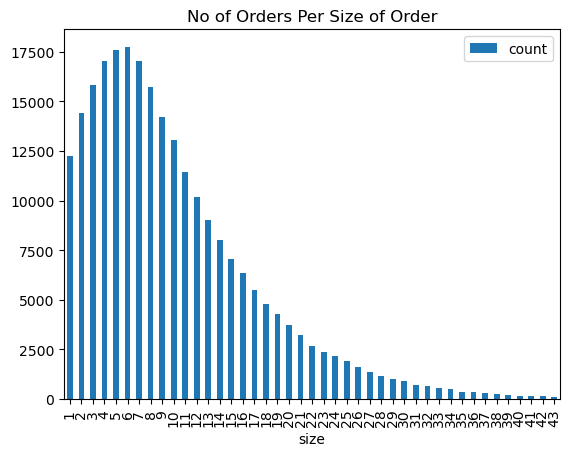

In [13]:
## there's a problem in the plot.. technically it did exactly what we asked it to do
## how can we fix it?
myPlot = dfCountPerSizePandas.sort_values('size').plot(x="size", y="count",kind="bar", title="No of Orders Per Size of Order")


## Exercise 5

Can you plot the department based on their onshelf products? In other words, can you display the departments based on their number of products?

<AxesSubplot: title={'center': 'No of Products Per Department'}>

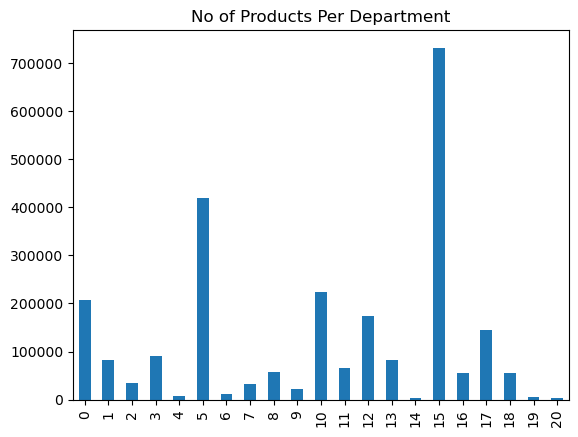

In [38]:
dfSelectedOrders = dfFullOrders.groupBy(col('department_id')).agg(collect_list(col('count')).alias('product_count'))
# dfSelectedOrders.show()
dfSelectedOrdersPandas = dfSelectedOrders.toPandas()
dfSelectedOrdersPandasSummed = dfSelectedOrdersPandas['product_count'].apply(sum)
dfSelectedOrdersPandasSummed.plot(x='department_id', y='count', kind='bar', title='No of Products Per Department')

## Exercise 6
Can you plot the number of orders in each day of a week? From there, can you find out the highest order placed day and the lowest order placed day of the week?

<AxesSubplot: title={'center': 'No of Orders'}, xlabel='order_dow'>

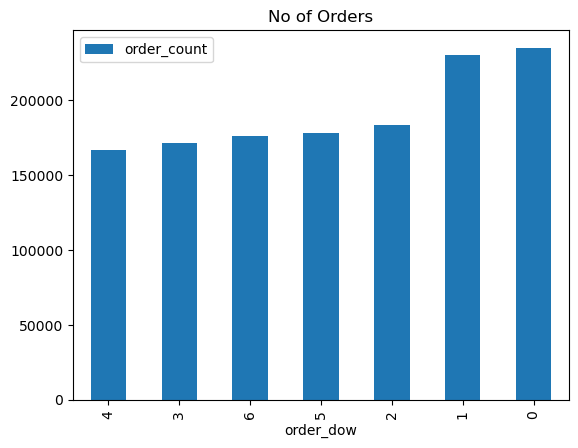

In [52]:
dfSelectedOrders = dfOrders.groupBy(col('order_dow')).agg(collect_list(col('order_id')).alias('orders'))
dfSizeOfOrders = dfSelectedOrders.select(col('order_dow'), size('orders').alias('order_count'))
dfSelectedOrdersPandas = dfSizeOfOrders.toPandas()
dfSelectedOrdersPandas.sort_values('order_count').plot(x='order_dow', y='order_count', kind='bar', title='No of Orders')

The day with the lowest number of orders placed is Thursday, the day with the highest number of orders placed is Sunday.

## Exercise 7

Can you plot and find out the hour_of_the_day which has the highest number of placed orders in a complete 7 days of a week?

<AxesSubplot: title={'center': 'No of Orders Per Hour'}, xlabel='order_hour_of_day'>

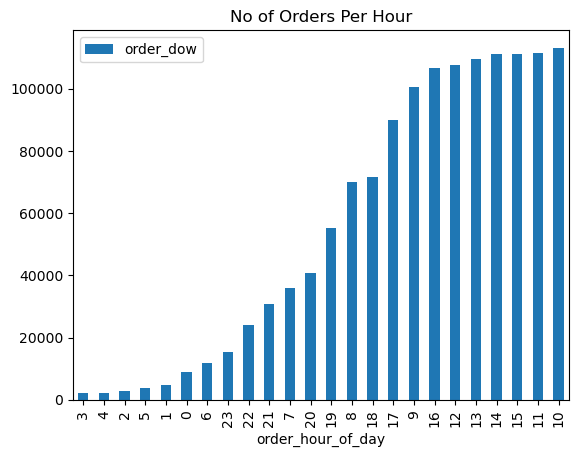

In [56]:
dfHours = dfOrders.groupBy(col('order_hour_of_day')).agg(collect_list(col('order_dow')).alias('order_dow'))
dfTarget = dfHours.select(col('order_hour_of_day'), size('order_dow').alias('order_dow'))
dfTargetPandas = dfTarget.toPandas()
dfTargetPandas.sort_values('order_dow').plot(x='order_hour_of_day', y='order_dow', kind='bar', title='No of Orders Per Hour')

The 10th hour has the most orders placed than any other hours.

# Advanced data analysis

## Getting the number of orders per hour of day per day of a week

The following code block will give us orders of per_hour_of_day as well as orders of per_hour_of_7_days of a week.

In [58]:
fullDf = None #this df will join all 7 dfs together. it is starting None
for i in  range(7): #go through the 7 days 0 to 6
    ''' 
    filter the orders depending on the day 0-6 
    groupBy the hours to be able to count how many orders per hour of day
    counting every group, how many orders it has.
    sorting based on the hour of day
    giving the count column an alias with 0-6 to indicate it is a count for what day
    '''
    tempDf = dfOrders.filter(col('order_dow') == str(i)) \
    .select(col("order_hour_of_day").cast("int").alias('order_hour_of_day')) \
    .groupBy(col('order_hour_of_day'))\
    .count()\
    .orderBy(col('order_hour_of_day').asc())\
    .select('order_hour_of_day', col('count').alias('count'+str(i))) 
    '''count str(i) represents each day of a week. Count0 means sunday'''

    
    if fullDf != None: #if the fullDf is actually a df and not None, we will join it with the new df 
        fullDf = fullDf.join(tempDf, 'order_hour_of_day')
    else: 
        fullDf = tempDf #if fullDf is None it means this is i=0 and we will just use this df as the first one to be joined with the rest
        

fullDf.show()

+-----------------+------+------+------+------+------+------+------+
|order_hour_of_day|count0|count1|count2|count3|count4|count5|count6|
+-----------------+------+------+------+------+------+------+------+
|               12| 20351| 18585| 14057| 13087| 12585| 14114| 14800|
|               22|  4445|  3497|  3179|  3249|  3462|  2953|  3380|
|                1|   889|   712|   597|   573|   590|   642|   733|
|               13| 21067| 18650| 14511| 13484| 12903| 14227| 14725|
|               16| 19279| 17590| 14842| 13782| 13296| 13897| 14023|
|                6|  1250|  2142|  1869|  1740|  1764|  1917|  1240|
|                3|   393|   296|   288|   257|   264|   345|   301|
|               20|  7177|  6253|  5829|  5354|  5648|  5234|  5229|
|                5|   495|   630|   576|   519|   475|   615|   434|
|               19|  8924|  8761|  7863|  7436|  7599|  7467|  7153|
|               15| 21088| 18221| 14883| 14192| 13318| 14729| 14825|
|                9| 15847| 20127| 

Now, we need to plot the resulted dataframe. We first needs to convert it to Pandas dataframe and then we need to plot the data in a timeseries plot.


<AxesSubplot: xlabel='order_hour_of_day'>

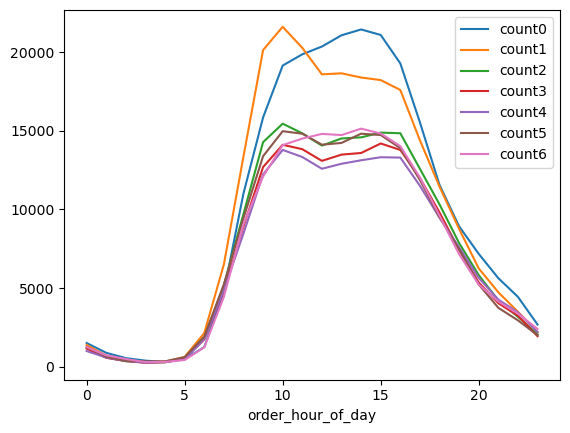

In [59]:
pdf = fullDf.orderBy('order_hour_of_day').toPandas()
pdf = pdf.set_index('order_hour_of_day') # This will set the x-axis values to follow the hour of the day.
pdf.plot()

You can check the colormap available in matplotlib here 
https://matplotlib.org/stable/tutorials/colors/colormaps.html
and we can pass the name of the colormap to the plot function 

<AxesSubplot: xlabel='order_hour_of_day'>

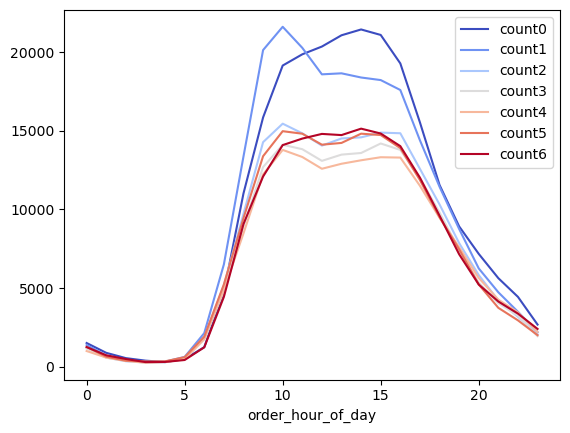

In [60]:
pdf.plot(colormap="coolwarm")

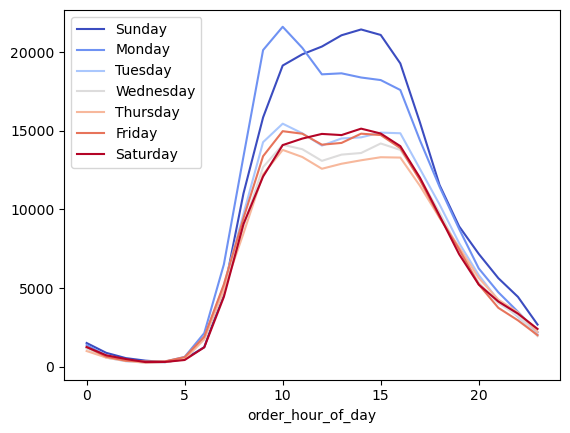

In [61]:
#we can even change the legend of the returned plot
pdf.plot(colormap="coolwarm").legend([
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
])



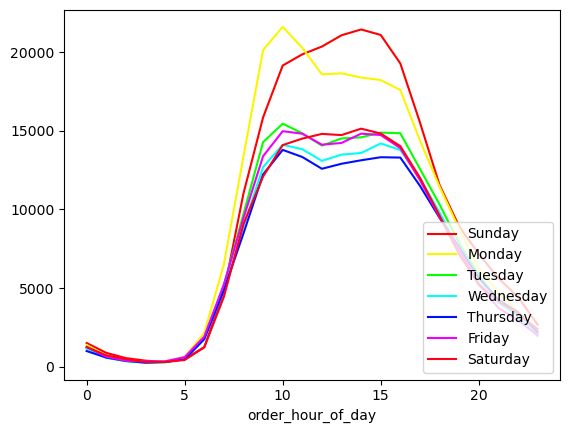

In [62]:
#some changes might be done automatically for the legend not to cover the plot
#but we can also change the location of the legend. the default value of loc is 'best'
#i also changed the colormap for fun
pdf.plot(colormap="hsv").legend([
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
],
loc="lower right")
#you can read here about the legend docs https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html

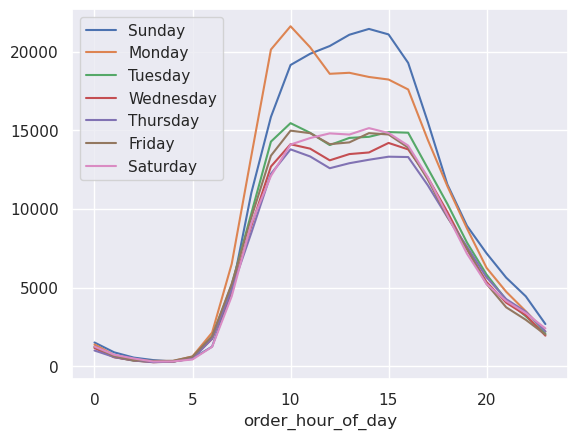

In [63]:
#but wait.. there's more
# we can use seaborn library 
# https://seaborn.pydata.org/index.html
# and set a theme style for plotting from the library
# which will work with matplotlib and pandas
import seaborn as sns
sns.set_theme(style="darkgrid")

#you can read what set_theme does here
# https://seaborn.pydata.org/generated/seaborn.set_theme.html?highlight=themes

pdf.plot().legend([
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
],
loc="best")

## Exercise 8

I have added a new dataset, EI_DJTA_20160128_Trades.csv, which lists all the active trade products name with the sales time and sales amount (volumes). Pick up the 10 most sold Trading tickers (product) from the given data. After that, plot them in chart which will represent the relation between sales the time of trade market and volumes sold for each of the 10 products altogether.

In [234]:
dfTrades = ss.read.csv('EI_DJTA_20160128_Trades.csv', header=True, inferSchema=True)

tickerSums = dfTrades.groupBy(col('Ticker')).agg(sum('Quantity').alias('Quantity'))
dfTickerSums = tickerSums.select(col('Ticker'), col('Quantity'))
dfTickerSums.show()


dfTimeStamps = dfTrades.select(col('Ticker'), col('Timestamp'))
dfFormattedTS = dfTimeStamps.withColumn('Timestamp', when(dfTimeStamps.Timestamp[4:2] < "30", (dfTimeStamps.Timestamp[0:2] + 0.5)).otherwise(dfTimeStamps.Timestamp[0:2] + 1))
dfGrouppedTS = dfFormattedTS.groupBy('Ticker').pivot('Ticker').sum('Timestamp')
dfGrouppedTS.show()
# dfFullTS = dfTickerSums.join(dfGrouppedTS, 'Ticker')
# dfTenTS = dfFullTS.orderBy(col('quantity').desc()).limit(10)

# pds = dfTenTS.toPandas()
# pds = pds.set_index('Ticker')
# pds.plot()

+------+--------+
|Ticker|Quantity|
+------+--------+
|   CAR| 2226099|
|  CHRW| 1887213|
|  JBLU|11280260|
|   KSU| 1523589|
|   KEX| 2381433|
|   CSX| 5416253|
|  LSTR| 1113652|
|   UNP| 6217372|
|   NSC| 1260316|
|   UAL| 6942956|
|  EXPD| 1497093|
|   DAL|12704822|
|   AAL|15215241|
|   FDX| 1420759|
|     R| 1032311|
|  JBHT|  884927|
|   ALK| 1339315|
|  MATX|  222119|
|   UPS| 2097202|
|   LUV| 8084434|
+------+--------+

+------+---------+--------+--------+--------+--------+---------+--------+--------+--------+---------+--------+--------+--------+---------+-------+--------+--------+--------+--------+--------+
|Ticker|      AAL|     ALK|     CAR|    CHRW|     CSX|      DAL|    EXPD|     FDX|    JBHT|     JBLU|     KEX|     KSU|    LSTR|      LUV|   MATX|     NSC|       R|     UAL|     UNP|     UPS|
+------+---------+--------+--------+--------+--------+---------+--------+--------+--------+---------+--------+--------+--------+---------+-------+--------+--------+--------+--------+-